In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from astropy import constants as const
from astropy import units as u

In [48]:
# Definiendo constantes
G = const.G.to(u.cm**3/(u.g*u.s**2)) # Constante Gravitacional en cm^3/(g*s^2)
Msol = const.M_sun.to(u.g) # Masa solar en gramos
R_sol = const.R_sun.to(u.cm)  # Radio del sol en centímetros

# 1. Definir q y $\Omega_*$

In [49]:
# Read the CSV file with space as the delimiter
data = pd.read_csv('solar-model_Christensen-Dalsgaard_simple.txt', delim_whitespace=True,)
data

,r/R,c_cm/sec,rho_g/cm^3,p_dyn/cm^2,Gamma_1,T_k
0,1.000713,686438.80,3.292483e-09,9.455764e+02,1.640705,4.348196e+03
1,1.000705,686573.05,3.469053e-09,9.962773e+02,1.641361,4.348491e+03
2,1.000697,686706.53,3.656545e-09,1.050125e+03,1.641997,4.348819e+03
3,1.000689,686840.63,3.855586e-09,1.107302e+03,1.642618,4.349183e+03
4,1.000681,686977.49,4.066838e-09,1.168000e+03,1.643233,4.349587e+03
...,...,...,...,...,...,...
2477,0.001448,50466295.00,1.538629e+02,2.348911e+17,1.668285,1.566774e+07
2478,0.001429,50466263.00,1.538637e+02,2.348920e+17,1.668284,1.566776e+07
2479,0.001410,50466228.00,1.538645e+02,2.348929e+17,1.668285,1.566778e+07
2480,0.001391,50466228.00,1.538650e+02,2.348937e+17,1.668284,1.566779e+07


In [50]:
data = data.sort_values(by='r/R').reset_index(drop=True)
data

,r/R,c_cm/sec,rho_g/cm^3,p_dyn/cm^2,Gamma_1,T_k
0,0.000000,50465569.00,1.538894e+02,2.349248e+17,1.668285,1.566847e+07
1,0.001391,50466228.00,1.538650e+02,2.348937e+17,1.668284,1.566779e+07
2,0.001410,50466228.00,1.538645e+02,2.348929e+17,1.668285,1.566778e+07
3,0.001429,50466263.00,1.538637e+02,2.348920e+17,1.668284,1.566776e+07
4,0.001448,50466295.00,1.538629e+02,2.348911e+17,1.668285,1.566774e+07
...,...,...,...,...,...,...
2477,1.000681,686977.49,4.066838e-09,1.168000e+03,1.643233,4.349587e+03
2478,1.000689,686840.63,3.855586e-09,1.107302e+03,1.642618,4.349183e+03
2479,1.000697,686706.53,3.656545e-09,1.050125e+03,1.641997,4.348819e+03
2480,1.000705,686573.05,3.469053e-09,9.962773e+02,1.641361,4.348491e+03


### Despejando r


In [51]:
r=data["r/R"]*R_sol
display(r)


0       0.000000e+00
1       9.677883e+07
2       9.807979e+07
3       9.940162e+07
4       1.007374e+08
            ...     
2477    6.961736e+10
2478    6.961792e+10
2479    6.961848e+10
2480    6.961903e+10
2481    6.961958e+10
Name: r/R, Length: 2482, dtype: float64

In [52]:
rho=data["rho_g/cm^3"].values
print(rho)

[1.5388936e+02 1.5386501e+02 1.5386447e+02 ... 3.6565446e-09 3.4690527e-09
 3.2924832e-09]


 ### A continuación calculamos la integral de la masa utilizando el método del trapecio 
 $M(r)=4\pi \int_0^{r} \rho(r')r'^{2} dr'$

In [53]:
def calculate_mass_within_radius(r, rho):
    integral = integrate.cumtrapz(rho*r**2, r, initial=0)
    M = (4*np.pi*integral)
    return M

In [54]:
M_r = calculate_mass_within_radius(r, rho)
print(M_r)



[0.00000000e+00 8.76316118e+26 9.00194844e+26 ... 1.98652582e+33
 1.98652582e+33 1.98652582e+33]


### Luego con el valor hallado en M , hallamos la integral de la energía potencial del sistema, para la cual también se utilizó el método del trapecio 
$\Omega=4 \cdot \pi\cdot G \int_{0}^{R} M(r)\rho(r)r dr$


In [55]:
def Energy(M, rho, r):
    integral = integrate.cumtrapz(M*rho*r, r) *(u.g**2 / u.cm)    # Using Simpson's rule for total integral
    Omega = (-4*np.pi*G*integral ).to(u.erg)
    return Omega

In [56]:
# Calculate the gravitational potential at radius R_sol
x = np.linspace(0, R_sol, num=2402)
Omega = Energy(M_r,rho,r)
print(Omega[-1])

-6.110233530610976e+48 erg


### Finalmente  hallamos el valor de q de la siguiente manera 
$q=-\frac{\Omega_\odot R_\odot}{GM_\odot^{2}}$


In [69]:
GMS2 =  (G * Msol**2)/R_sol
GMS2 = GMS2.to(u.erg)
GMS2

<Quantity 3.7931109e+48 erg>

In [70]:
q= -Omega[-1] / GMS2

print(q)

1.6108765822181692


### 2 ) Hacer un gráfico de $\Gamma_1$


In [58]:
Gamma_1 = data["Gamma_1"]
display(Gamma_1)

0       1.668285
1       1.668284
2       1.668285
3       1.668284
4       1.668285
          ...   
2477    1.643233
2478    1.642618
2479    1.641997
2480    1.641361
2481    1.640705
Name: Gamma_1, Length: 2482, dtype: float64

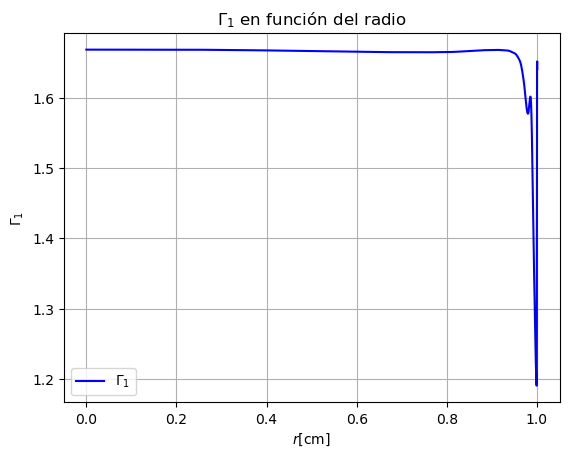

In [79]:
plt.plot(data["r/R"],Gamma_1, '-',c='blue',label= r'$\Gamma_1$' )
plt.xlabel(r'$r$[cm]' )
plt.ylabel(r'$\Gamma_1$')
plt.title(r'$\Gamma_1 $ en función del radio')
plt.legend()
plt.grid(True)
plt.show()

### Como se observa en la gráfica el valor de $\Gamma_1$ se mantiene estabel, sin embargo par ciertos radios este valor disminuye y luego vuelve a aumentar a un valor similar al inicial. Esto supone que puede haber en el estado de ionizacion de en el sol 

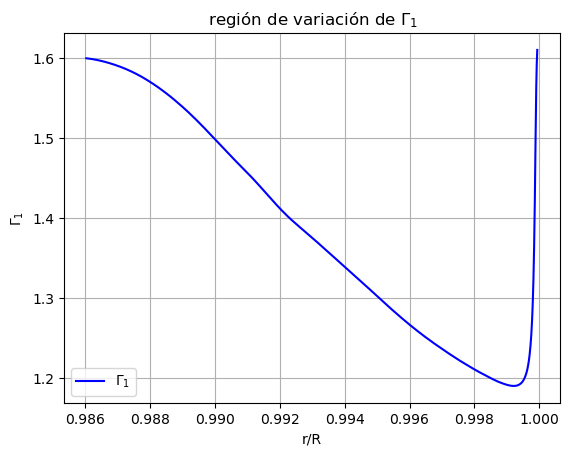

In [116]:
plt.plot(data["r/R"][1770:2380],Gamma_1[1770:2380], '-',c='blue',label= r'$\Gamma_1$' )
plt.xlabel(r'r/R' )
plt.ylabel(r'$\Gamma_1$')
plt.title(r' región de variación de $\Gamma_1 $ ')
plt.legend()
plt.grid(True)
plt.show()

### 3) Graficar $T_k$ y $\rho(r)$

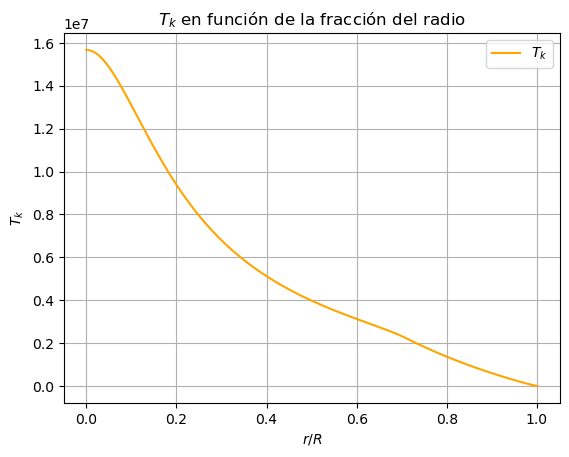

In [112]:
T_k = data["T_k"]
plt.plot(data["r/R"], T_k, '-',c='orange',label= r'$T_k$' )
plt.xlabel(r'$r/R$' )
plt.ylabel(r'$T_k$')
#plt.yscale("log")
plt.title(r'$T_k $ en función de la fracción del radio')
plt.legend()
plt.grid(True)
plt.show()

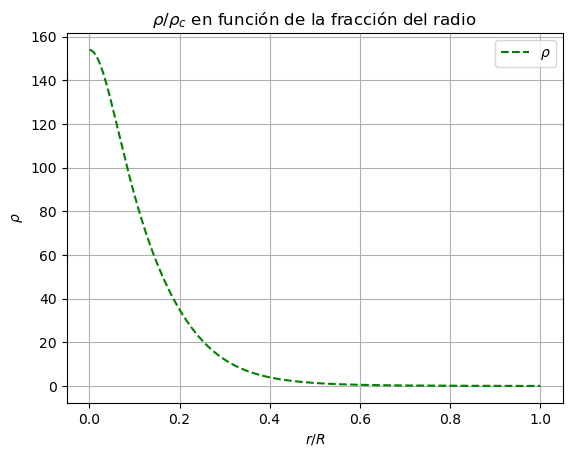

In [117]:
plt.plot(data["r/R"],rho, '--',c='green',label= r'$\rho$' )
plt.xlabel(r'$r/R$' )
plt.ylabel(r'$\rho$')
#plt.yscale("log")
plt.title(r'$\rho/\rho_c $ en función de la fracción del radio ')
plt.legend()
plt.grid(True)
plt.show()

### En ambos casos el valor de la temperatura disminuye a medida de que el radio vaya aumentando y tiene su máximo en el centro de la estrella que es lo que se esperaba.